# Basic Synthetic Data Generation with DeepBridge

This tutorial demonstrates how to generate synthetic data using the DeepBridge library. I'll walk you through creating synthetic datasets with different methods and comparing their results.

## Overview

In this demonstration, we'll:
1. Create a sample dataset with mixed data types
2. Generate synthetic versions using three different methods:
   - Gaussian Copula
   - CTGAN (Conditional Tabular GAN)
   - UltraLight Generator
3. Evaluate and compare the quality of each method
4. Visualize the differences between original and synthetic data

## Understanding the Different Methods

Each synthetic data generation method has its unique characteristics:

### Gaussian Copula
- Statistical method that preserves the marginal distributions and correlations between features
- Good balance between quality and computational efficiency
- Works well for numerical data with linear relationships
- Medium memory requirements

### CTGAN (Conditional Tabular GAN)
- Neural network-based approach using Generative Adversarial Networks
- Can capture complex, non-linear relationships in the data
- Highest quality for capturing complex patterns
- More computationally intensive and requires more memory
- Longer training time

### UltraLight Generator
- Simplest and fastest approach with minimal memory requirements
- Uses basic statistical modeling rather than complex ML models
- Excellent for large datasets or limited computational resources
- Quality may be lower for complex relationships

## Example Implementation

Let's look at the code to implement these methods:

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


import sys
import os

sys.path.append(os.path.expanduser("~/projetos/DeepBridge"))


from deepbridge.core.db_data import DBDataset
from deepbridge.synthetic import Synthesize
from deepbridge.validation import Validator, test_model_robustness, plot_robustness_results, summary_report


#---------------------------------------------------------
# Preparação de dados com cuidado especial 
#---------------------------------------------------------
print("Carregando e preparando dados...")

# Carregar dados
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Verificar e lidar com valores ausentes
print(f"Valores NaN em X antes da limpeza: {X.isna().sum().sum()}")
print(f"Valores infinitos em X: {np.isinf(X.values).sum()}")

# Resetar índices para garantir alinhamento limpo
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Resetar índices novamente após a divisão
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Criar DataFrames de treino e teste com nomes explícitos de colunas
train_df = X_train.copy()
train_df['target'] = y_train
test_df = X_test.copy()
test_df['target'] = y_test

# Verificação final
print(f"NaN em train_df: {train_df.isna().sum().sum()}")
print(f"NaN em test_df: {test_df.isna().sum().sum()}")

# Treinar modelo
print("\nTreinando modelo...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Criar objeto de dataset
print("\nCriando objeto de dataset...")
dataset = DBDataset(
    train_data=train_df,
    test_data=test_df,
    target_column='target',
    model=model
)



/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregando e preparando dados...
Valores NaN em X antes da limpeza: 0
Valores infinitos em X: 0
NaN em train_df: 0
NaN em test_df: 0

Treinando modelo...

Criando objeto de dataset...


/home/guhaase/projetos/DeepBridge/deepbridge/validation/frameworks/robustness/adversarial_robustness.py:30: UserWarning: TensorFlow not available. Some adversarial attacks may not work.
  warnings.warn("TensorFlow not available. Some adversarial attacks may not work.")


In [2]:
synthetic_df = Synthesize(
    dataset=dataset,
    method='gaussian',
    num_samples=1000,  
    verbose=False
)

/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34665 instead
  warnings.warn(
2025-03-24 11:20:04,448 - distributed.worker - ERROR - Compute Failed
Key:       _process_chunk_for_dask_standalone-b51ff9df-aa72-48eb-a989-1010c8a64cdc
State:     executing
Task:  <Task '_process_chunk_for_dask_standalone-b51ff9df-aa72-48eb-a989-1010c8a64cdc' apply(...)>
Exception: 'TypeError("unsupported operand type(s) for +: \'NoneType\' and \'int\'")'
Traceback: '  File "/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/dask/utils.py", line 77, in apply\n    return func(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^\n  File "/home/guhaase/projetos/DeepBridge/deepbridge/synthetic/methods/gaussian_copula.py", line 62, in _process_chunk_for_dask_standalone\n    np.random.seed(random_state + chunk_id)\n                   ~~


===== SYNTHETIC DATA QUALITY EVALUATION =====

OVERALL METRICS:
  - quality_score: 0.9562 (Excellent)
  - statistical_similarity: 0.9416 (Excellent)
  - privacy_score: 1.0000 (Excellent)
  - utility_score: 0.9416 (Excellent)

STATISTICAL METRICS:
  - avg_ks_statistic: 0.0568
  - avg_jensen_shannon_dist: 0.1521
  - correlation_mean_difference: 0.0600

PRIVACY METRICS:
  - Records at privacy risk: 0.00% (Low risk)
  - Average distance to nearest record: 2.8470

UTILITY METRICS:
  - distribution_similarity: 0.9432
  - correlation_preservation: 0.9400


Calculating similarity between original and synthetic data...
Inferred 30 numerical columns and 1 categorical columns
Using standard approach for similarity calculation
Similaridade média: 0.4623
Similaridade mínima: 0.0746
Similaridade máxima: 0.7396


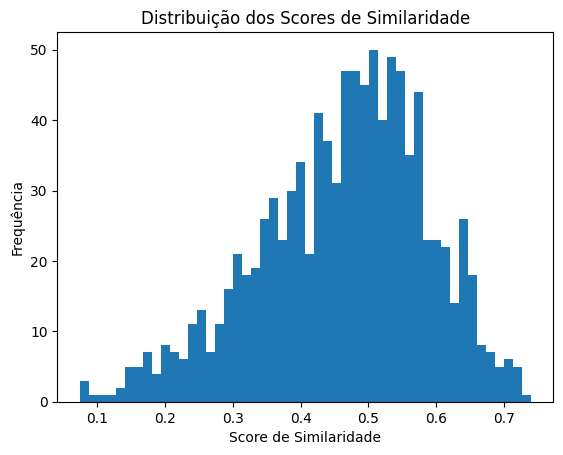

In [3]:
from deepbridge.synthetic.metrics.similarity import calculate_similarity

# Acesse os dados originais e os dados sintéticos
original_data = synthetic_df.original_data
synthetic_data = synthetic_df.data

# Calcule a similaridade
similarity_scores = calculate_similarity(
    original_data=original_data,
    synthetic_data=synthetic_data,
    # Parâmetros opcionais:
    metric='euclidean',         # Métrica de distância a ser usada
    n_neighbors=5,              # Número de vizinhos a considerar
    sample_size=10000,          # Tamanho máximo da amostra a usar
    random_state=42,            # Seed para reprodutibilidade
    verbose=True                # Mostrar informações de progresso
)

# similarity_scores é um pandas.Series com um score para cada amostra sintética
# Valores mais próximos de 1 indicam maior similaridade (mais parecidos)
# Valores mais próximos de 0 indicam menor similaridade (mais diferentes)

# Estatísticas de similaridade
print(f"Similaridade média: {similarity_scores.mean():.4f}")
print(f"Similaridade mínima: {similarity_scores.min():.4f}")
print(f"Similaridade máxima: {similarity_scores.max():.4f}")

# Você também pode visualizar a distribuição dos scores
import matplotlib.pyplot as plt
plt.hist(similarity_scores, bins=50)
plt.title('Distribuição dos Scores de Similaridade')
plt.xlabel('Score de Similaridade')
plt.ylabel('Frequência')
plt.show()

In [4]:
from deepbridge.synthetic.metrics.similarity import filter_by_similarity

# Filtra dados com similaridade acima de um limiar
filtered_data = filter_by_similarity(
    original_data=original_data,
    synthetic_data=synthetic_data,
    threshold=0.9,              # Remove samples com similaridade >= 0.9
    verbose=True
)

print(f"Amostras originais: {len(synthetic_data)}")
print(f"Amostras após filtragem: {len(filtered_data)}")

Filtering synthetic data with similarity threshold: 0.9
Inferred 30 numerical columns and 1 categorical columns
Calculating similarity between original and synthetic data...
Using standard approach for similarity calculation
Removed 0 samples (0.00%) with similarity ≥ 0.9
Amostras originais: 1000
Amostras após filtragem: 1000


In [5]:
# Avaliação da diversidade dos dados sintéticos
from deepbridge.synthetic.metrics.similarity import calculate_diversity

diversity_metrics = calculate_diversity(
    synthetic_data=synthetic_df.data,
    verbose=True
)

# Avaliação das diferenças de correlação entre variáveis numéricas
from deepbridge.synthetic.metrics.similarity import evaluate_pairwise_correlations

correlation_analysis = evaluate_pairwise_correlations(
    original_data=original_data,
    synthetic_data=synthetic_data
)

# Mostrar pares de colunas com maiores diferenças de correlação
print(correlation_analysis.head(10))

Calculating synthetic data diversity...
Diversity calculation complete
                  column1 column2  original_corr  synthetic_corr  difference  \
188        mean concavity  target      -0.696360       -0.421684   -0.274675   
419          worst radius  target      -0.776454       -0.501800   -0.274653   
436       worst perimeter  target      -0.782914       -0.509702   -0.273212   
211   mean concave points  target      -0.776614       -0.514439   -0.262175   
86         mean perimeter  target      -0.742636       -0.490487   -0.252149   
29            mean radius  target      -0.730029       -0.479385   -0.250644   
461  worst concave points  target      -0.793566       -0.550712   -0.242854   
443            worst area  target      -0.733825       -0.492548   -0.241277   
113             mean area  target      -0.708984       -0.470339   -0.238645   
458       worst concavity  target      -0.659610       -0.425291   -0.234319   

     abs_difference  is_significant  
188       

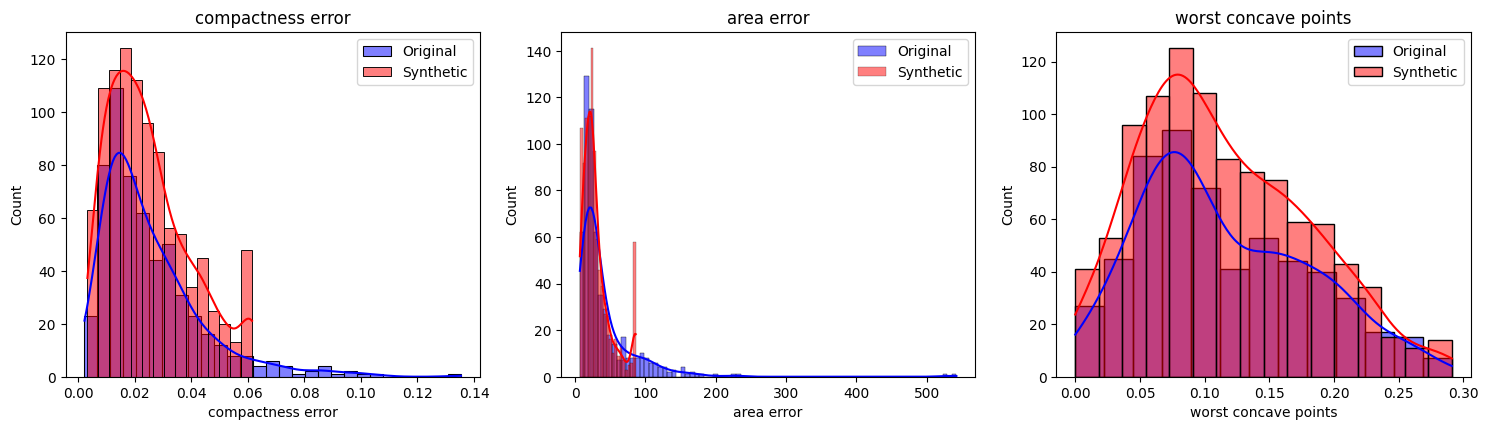

In [6]:
try:
    from deepbridge.synthetic.metrics.similarity import plot_distribution_comparison
    
    fig = plot_distribution_comparison(
        original_data=original_data,
        synthetic_data=synthetic_data
    )
    plt.show()
except ImportError:
    print("Módulo de visualização não disponível")

In [7]:
# Gerando um relatório HTML
report_path = synthetic_df.save_report("relatorio_dados_sinteticos.html")
print(f"Relatório gerado e salvo em: {report_path}")

Report saved to: relatorio_dados_sinteticos.html
Relatório gerado e salvo em: relatorio_dados_sinteticos.html


In [8]:
X = synthetic_df.data.drop('target', axis=1)
y = synthetic_df.data['target']

In [9]:
y_pred = model.predict(X)

In [10]:
# # 6. Avaliação do modelo
# accuracy = accuracy_score(y, y_pred)
# report = classification_report(y, y_pred)

# print(report)


Método 1: Usando a função robusta test_model_robustness...
Baseline score: 0.9708
Testing perturbation size: 0.01
  Score: 0.9708, Predictions changed: 0.00%
Testing perturbation size: 0.05
  Score: 0.9708, Predictions changed: 1.17%
Testing perturbation size: 0.1
  Score: 0.9708, Predictions changed: 2.34%
Testing perturbation size: 0.2
  Score: 0.9766, Predictions changed: 1.75%
Visualização de robustez criada. Feche a janela da figura para continuar.

Método 2: Análise de resiliência via interface atualizada...
Erro na análise de resiliência: No module named 'deepbridge.validation.robustness_validator'

Método 3: Análise de importância de hiperparâmetros...
Erro na análise de importância: No module named 'DeepBridge'

Exemplos de validação concluídos.


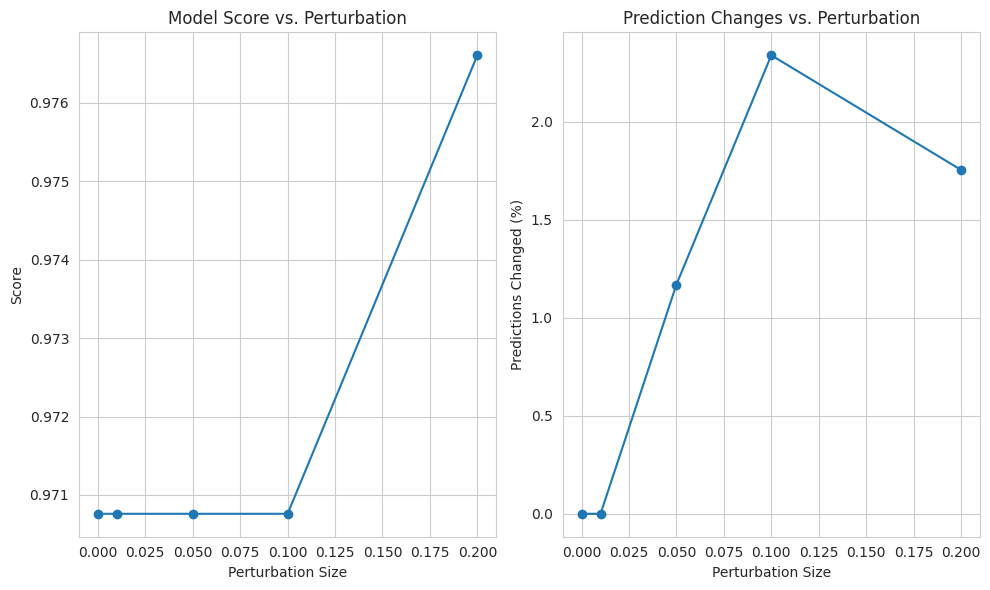

In [11]:
#---------------------------------------------------------
# Método 1: Usando a função simplificada robusta
#---------------------------------------------------------
print("\nMétodo 1: Usando a função robusta test_model_robustness...")

robustness_results = test_model_robustness(
    model=model,
    X_test=X_test,
    y_test=y_test,
    perturbation_sizes=[0.01, 0.05, 0.1, 0.2],
    perturb_method='raw',
    metric='accuracy'
)

# Visualizar resultados
fig = plot_robustness_results(robustness_results)
print("Visualização de robustez criada. Feche a janela da figura para continuar.")

#---------------------------------------------------------
# Método 2: Usando a interface atualizada para resilience
#---------------------------------------------------------
print("\nMétodo 2: Análise de resiliência via interface atualizada...")

try:
    resilience_results = Validator(dataset, "resilience", 
                                alpha=0.3,         # Foco nos 30% piores
                                distance_metric="PSI",
                                show="none")       # Não mostrar gráficos
    
    # Imprimir resultados relevantes
    print("\nTop features com shift de distribuição:")
    for i, (feature, shift) in enumerate(list(resilience_results['top_features'].items())[:3]):
        print(f"  {i+1}. {feature}: {shift:.4f}")
    
    # Acessar métricas de desempenho
    metrics = resilience_results['performance_metrics']
    if 'worst_auc' in metrics:
        print(f"\nAUC nas piores amostras: {metrics['worst_auc']:.4f}")
        print(f"AUC nas amostras restantes: {metrics['remaining_auc']:.4f}")
        print(f"Gap de desempenho: {metrics['performance_gap_auc']:.4f}")
except Exception as e:
    print(f"Erro na análise de resiliência: {str(e)}")

#---------------------------------------------------------
# Método 3: Usando a análise de importância de hiperparâmetros
#---------------------------------------------------------
print("\nMétodo 3: Análise de importância de hiperparâmetros...")

# Define grade de parâmetros
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

# Acesso direto ao validador para evitar problemas com a função wrapper
try:
    from deepbridge.validation.base_validator import BaseValidator
    
    base_validator = BaseValidator(dataset, model)
    importance_results = base_validator.hyperparameter_validator.analyze_hyperparameter_importance(
        model_class=RandomForestClassifier,
        param_grid=param_grid,
        metric='accuracy',
        problem_type='classification',
        cv=3,             # Menor CV para velocidade
        n_subsamples=2,   # Apenas 2 subamostras para velocidade
        subsample_size=0.3 # Subamostra pequena para velocidade
    )
    
    # Imprimir importância ordenada
    print("\nImportância de hiperparâmetros (ordenada):")
    for param, score in importance_results['ordered_importance'].items():
        print(f"  {param}: {score:.4f}")
    
    # Visualizar importância
    fig = base_validator.hyperparameter_validator.visualize_importance()
    print("Visualização de importância criada. Feche a janela da figura para continuar.")
except Exception as e:
    print(f"Erro na análise de importância: {str(e)}")

print("\nExemplos de validação concluídos.")

In [12]:
from deepbridge.validation.base_validator import BaseValidator
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Criar um conjunto de dados simples
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar um modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Criar uma classe simples para simular o DBDataset
class SimpleDataset:
    def __init__(self, X_train, y_train, X_test, y_test, model):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        
    def get_feature_data(self, dataset='train'):
        if dataset == 'train':
            return self.X_train
        else:
            return self.X_test
            
    def get_target_data(self, dataset='train'):
        if dataset == 'train':
            return self.y_train
        else:
            return self.y_test
            
    def __len__(self):
        return len(self.X_train) + len(self.X_test)

# Criar o dataset
dataset = SimpleDataset(X_train, y_train, X_test, y_test, model)

# Criar o validador
validator = BaseValidator(dataset, model)

# Executar validação incluindo testes adversariais
results = validator.validate_model(
    validate_robustness=True,
    validate_uncertainty=False,
    validate_hyperparameters=False,
    validate_adversarial=True,
    adversarial_kwargs={
        'attack_types': ['fgsm'],  # Para execução mais rápida
        'epsilons': [0.1],
        'metrics': ['accuracy']
    }
)

# Visualizar resultados adversariais
fig = validator.visualize_results(
    result_type='adversarial',
    specific_aspect='attack_success'
)

# Gerar relatório
report = validator.generate_validation_report(output_format='markdown')
print(report)

Validating model robustness...
Robustness validation failed: No module named 'deepbridge.validation.robustness_validator'
Validating model adversarial robustness...
Adversarial robustness validation failed: No module named 'deepbridge.validation.uncertainty'


ModuleNotFoundError: No module named 'deepbridge.validation.uncertainty'